In [1]:
import pandas as pd
import numpy as np 
from PyBundled.utils import  run_experiment


bundled_text is being imported


In [2]:
import spacy

nlp = spacy.load("en_core_web_lg",)

In [2]:
# load data 
data  = pd.read_csv('../data/bundled_raw.csv')

In [3]:
data.head()

,text,is_bundled
0,Emerson Community Experience,0
1,How could Emerson engage you in building a str...,0
2,"Discuss racism, anti-Semitism all forms of dis...",1
3,Regular communication,0
4,give staff time for this work,0


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       368
           1       0.31      0.09      0.14        58

    accuracy                           0.85       426
   macro avg       0.59      0.53      0.53       426
weighted avg       0.79      0.85      0.81       426

------------------


<AxesSubplot:>

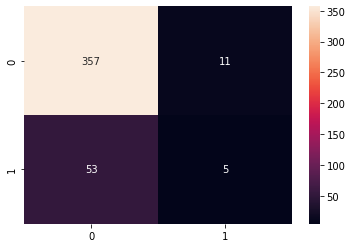

In [5]:
# count number of . in text
def count_dot(text):
    return text.count('.')
# count number of ? in text
def count_comma(text):
    return text.count(',')
# count number of non alphanumeric characters in text
def count_non_alphanumeric(text):
    numbers = sum(c.isdigit() for c in text)
    letters = sum(c.isalpha() for c in text)
    spaces  = sum(c.isspace() for c in text)
    others  = len(text) - numbers - letters - spaces
    return others
# count number of words in text
def count_words(text):
    return len(text.split())

def simple_feat_gen(data):
    data['dot_count'] = data['text'].apply(count_dot)
    data['comma_count'] = data['text'].apply(count_comma)
    data['non_alphanumeric_count'] = data['text'].apply(count_non_alphanumeric)
    data['word_count'] = data['text'].apply(count_words)
    return data[['dot_count','comma_count','non_alphanumeric_count','word_count','is_bundled']]

config = {
    'model_type': 'logistic',
    'feat_gen_func' : simple_feat_gen,
    'model_params': {} , 
    'cach_data': None

}
confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       368
           1       0.96      0.84      0.90        58

    accuracy                           0.97       426
   macro avg       0.97      0.92      0.94       426
weighted avg       0.97      0.97      0.97       426

------------------


<AxesSubplot:>

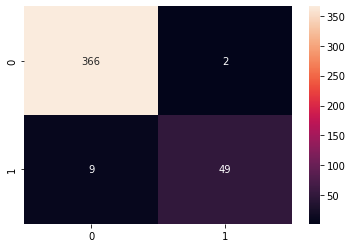

In [6]:
config = {
    'model_type': 'randomforest',
    'feat_gen_func' : simple_feat_gen,
    'model_params': {'n_estimators':20,} , 
    'cach_data': cach_data

}
confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       368
           1       0.31      0.09      0.14        58

    accuracy                           0.85       426
   macro avg       0.59      0.53      0.53       426
weighted avg       0.79      0.85      0.81       426

------------------


<AxesSubplot:>

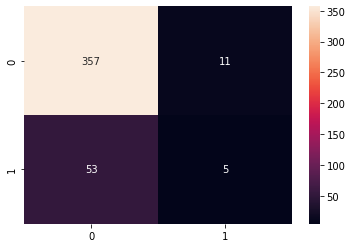

In [10]:
def split_into_sentences(text):
    doc = nlp(text)
    spans = []
    span =[]
    for token in doc : 
        if token.pos_=='PUNCT' and  token.text in [',','.','?','!',';'] :
            span_text = ' '.join(span)
            spans.append(span_text)
            span=[]
        else:
            span.append(token.text)
    span_text = ' '.join(span)
    spans.append(span_text)
    spans = [s for s in spans if s!='']
    return spans


def compute_similarity(pair):
    text1,text2 = pair
    doc1 = nlp(text1)
    doc2 = nlp(text2)
  
    return  doc1.similarity(doc2)

def get_sim_metrics(text):
    text_chunks = split_into_sentences(text)
    text_chunks_pairs = [text_chunks[i:i+2] for i in range(len(text_chunks)-1)]
    if len(text_chunks)<=1:
        return len(text_chunks),1,1
    similarity_scores = [compute_similarity(pair) for pair in text_chunks_pairs]
    return len(text_chunks),  np.mean(similarity_scores) , np.min(similarity_scores)

 

# apply to data 
def similarity_feat_gen(data):
    data['sentence_count'], data['similarity_mean'] ,data['similarity_min']= zip(*data['text'].map(get_sim_metrics))
    return data[['sentence_count','similarity_mean','similarity_min','is_bundled']]
config = {
    'model_type': 'logistic',
    'model_params': {},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': None

}

confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       368
           1       1.00      0.88      0.94        58

    accuracy                           0.98       426
   macro avg       0.99      0.94      0.96       426
weighted avg       0.98      0.98      0.98       426

------------------


<AxesSubplot:>

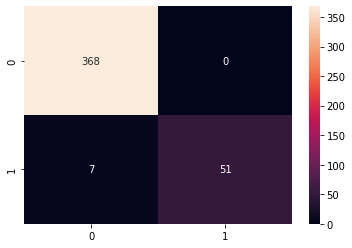

In [11]:
config = {
    'model_type': 'randomforest',
    'model_params': {'n_estimators':20,},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': cach_data

}
confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

In [12]:
print('------------------')
print('false negative texts',data[data.index.isin(fn_index)]['text'].values)

------------------
false negative texts ['Increase wages and financial aid'
 'hire more BIPOC professors and give them the resources they need'
 'diversity and equity concerns'
 'increasing the student loan and faculty salaries budgets and recruiting admissions/resumes from schools and communities with diverse student bodies'
 "My access to resources and a network I wouldn't have at any other school"
 'Passion & Creativity' 'Flexibility and gratitude']


              precision    recall  f1-score   support

           0       0.88      0.97      0.92       368
           1       0.47      0.16      0.23        58

    accuracy                           0.86       426
   macro avg       0.68      0.56      0.58       426
weighted avg       0.82      0.86      0.83       426

------------------


<AxesSubplot:>

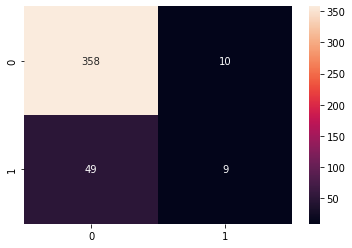

In [13]:
def split_into_sentences(text):
    doc = nlp(text)
    spans = []
    span =[]
    for token in doc : 
        if token.pos_=='PUNCT' and  token.text in [',','.','?','!',';'] :
            span_text = ' '.join(span)
            spans.append(span_text)
            span=[]
        else:
            span.append(token.text)
    span_text = ' '.join(span)
    spans.append(span_text)
    spans = [s for s in spans if s!='']
    return spans

# count number of stop words  
def count_stop_words(text):
    doc = nlp(text)
    return sum(token.is_stop for token in doc)

def compute_similarity(pair):
    text1,text2 = pair
    doc1 = nlp(text1)
    doc2 = nlp(text2)
  
    return  doc1.similarity(doc2)

def get_sim_metrics(text):
    text_chunks = split_into_sentences(text)
    text_chunks_pairs = [text_chunks[i:i+2] for i in range(len(text_chunks)-1)]
    if len(text_chunks)<=1:
        return len(text_chunks),1,1
    similarity_scores = [compute_similarity(pair) for pair in text_chunks_pairs]
    return len(text_chunks),  np.mean(similarity_scores) , np.min(similarity_scores)

 

# apply to data 
def similarity_feat_gen(data):
    data['sentence_count'], data['similarity_mean'] ,data['similarity_min']= zip(*data['text'].map(get_sim_metrics))
    data['stop_word_count'] = data['text'].apply(count_stop_words)
    return data[['sentence_count','similarity_mean','similarity_min','stop_word_count','is_bundled']]
config = {
    'model_type': 'logistic',
    'model_params': {},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': None

}

confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       368
           1       0.98      0.90      0.94        58

    accuracy                           0.98       426
   macro avg       0.98      0.95      0.96       426
weighted avg       0.98      0.98      0.98       426

------------------


<AxesSubplot:>

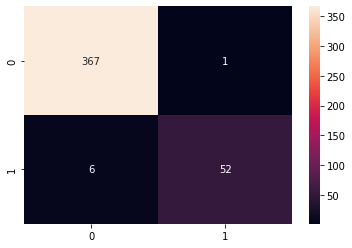

In [14]:
config = {
    'model_type': 'randomforest',
    'model_params': {'n_estimators':20,},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': cach_data

}
confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

In [15]:
print('------------------')
print('false negative texts',data[data.index.isin(fn_index)]['text'].values)

------------------
false negative texts ['Increase wages and financial aid'
 'hire more BIPOC professors and give them the resources they need'
 'diversity and equity concerns'
 'increasing the student loan and faculty salaries budgets and recruiting admissions/resumes from schools and communities with diverse student bodies'
 'Passion & Creativity' 'Flexibility and gratitude']


In [ ]:
# compute similarity using sentence-transformer 
!pip install -U sentence-transformers

In [17]:
from sentence_transformers import SentenceTransformer,util

model_name = 'all-mpnet-base-v2'

model = SentenceTransformer(model_name)



Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 106kB/s]
Downloading: 100%|██████████| 10.1k/10.1k [00:00<00:00, 2.51MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 9.77kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 180kB/s] 
Downloading: 100%|██████████| 349/349 [00:00<00:00, 91.3kB/s]
Downloading: 100%|██████████| 438M/438M [00:36<00:00, 12.2MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 20.4kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 109kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 1.11MB/s]
Downloading: 100%|██████████| 363/363 [00:00<00:00, 159kB/s]
Downloading: 100%|██████████| 13.1k/13.1k [00:00<00:00, 2.47MB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 560kB/s] 
Downloading: 100%|██████████| 190/190 [00:00<00:00, 70.4kB/s]


tensor([[0.0010]])

In [25]:
text1 = 'Increase wages and financial aid'
text2 ='diversity and equity concerns'
embeddings = model.encode([text1,text2])
sim = util.dot_score(embeddings[:,0], embeddings[:,1]).item()


0.0009530312963761389

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       368
           1       0.68      0.29      0.41        58

    accuracy                           0.88       426
   macro avg       0.79      0.64      0.67       426
weighted avg       0.87      0.88      0.86       426

------------------


<AxesSubplot:>

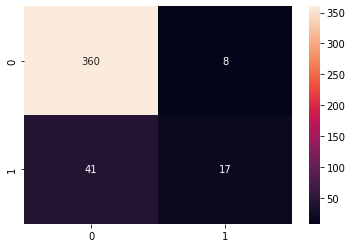

In [30]:
def split_into_sentences(text):
    doc = nlp(text)
    spans = []
    span =[]
    for token in doc : 
        if token.pos_=='PUNCT' and  token.text in [',','.','?','!',';'] :
            span_text = ' '.join(span)
            spans.append(span_text)
            span=[]
        else:
            span.append(token.text)
    span_text = ' '.join(span)
    spans.append(span_text)
    spans = [s for s in spans if s!='']
    return spans

# count number of stop words  
def count_stop_words(text):
    doc = nlp(text)
    return sum(token.is_stop for token in doc)

def compute_similarity(pair):
    text1,text2 = pair
    embeddings = model.encode([text1,text2])
    sim = util.dot_score(embeddings[:,0], embeddings[:,1]).item()
    return sim

def get_sim_metrics(text):
    text_chunks = split_into_sentences(text)
    text_chunks_pairs = [text_chunks[i:i+2] for i in range(len(text_chunks)-1)]
    if len(text_chunks)<=1:
        return len(text_chunks),1,1
    similarity_scores = [compute_similarity(pair) for pair in text_chunks_pairs]
    return len(text_chunks),  np.mean(similarity_scores) , np.min(similarity_scores)

 

# apply to data 
def similarity_feat_gen(data):
    data['sentence_count'], data['similarity_mean'] ,data['similarity_min']= zip(*data['text'].map(get_sim_metrics))
    data['stop_word_count'] = data['text'].apply(count_stop_words)
    return data[['sentence_count','similarity_mean','similarity_min','stop_word_count','is_bundled']]
config = {
    'model_type': 'logistic',
    'model_params': {},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': None

}

confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       368
           1       1.00      0.88      0.94        58

    accuracy                           0.98       426
   macro avg       0.99      0.94      0.96       426
weighted avg       0.98      0.98      0.98       426

------------------


<AxesSubplot:>

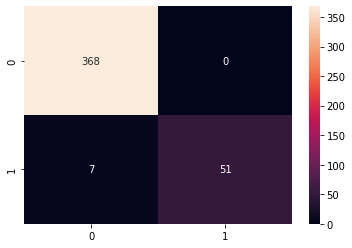

In [31]:
config = {
    'model_type': 'randomforest',
    'model_params': {'n_estimators':20,},
    'feat_gen_func' : similarity_feat_gen,
    'cach_data': cach_data

}
confusion_matrix, classification_report,features,fn_index,cach_data = run_experiment(data,config=config)
print(classification_report)

print('------------------')
# plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
# plot confusion matrix
sns.heatmap(confusion_matrix,annot=True,fmt='d')

In [32]:
print('------------------')
print('false negative texts',data[data.index.isin(fn_index)]['text'].values)

------------------
false negative texts ['Increase wages and financial aid'
 'hire more BIPOC professors and give them the resources they need'
 'diversity and equity concerns'
 'increasing the student loan and faculty salaries budgets and recruiting admissions/resumes from schools and communities with diverse student bodies'
 "My access to resources and a network I wouldn't have at any other school"
 'Passion & Creativity' 'Flexibility and gratitude']


In [44]:
data[(data['is_bundled']==1) &(data['text'].str.contains('and'))].sample(5)['text'].values

array(["I'm no expert but as a queer, trans, learning disabled, jewish student I want to see people like me and people nothing like me represented. International media and literature should be normal in a classroom setting. 0 tolerance for hate.",
       'increasing the student loan and faculty salaries budgets and recruiting admissions/resumes from schools and communities with diverse student bodies',
       'Hiring and retaining staff of color; identifying and addressing barriers for participation in abroad/domestic programs;',
       "I love being able to connect with students and faculty and help them. I think there is a sense of community among staff members that I appreciate. I think the benefits and the way staff are treated are better than a lot of places I've worked.",
       'The staff I work with directly are creative, hardworking, and engaged. They are always willing to collaborate and lend a hand when needed. Their focus is on creating the best experience and environment p

In [48]:
text = "Hiring and retaining staff of color; identifying and addressing barriers for participation in abroad/domestic programs;"
text1,text2 = text.split('and')[:2]
embeddings = model.encode([text1,text2])
sim = util.dot_score(embeddings[:,0], embeddings[:,1]).item()
sim

0.002117107156664133